# Titanic survival - Logistic regression
 Pridect the survival of Titanic passengers

In [1]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('titanic').getOrCreate()

In [4]:
df= spark.read.csv('titanic.csv',inferSchema=True,header=True)

In [5]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [6]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

## Feature engineering

In [7]:
# select columns to keep and drop irrelavent ones
my_cols = df.select(['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked'])

In [8]:
my_final_data = my_cols.na.drop()

In [9]:
# data to use
my_final_data.show(5)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



### Add categorical variables for: Sex and Embarked

In [10]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [11]:
gender_indexer = StringIndexer(inputCol='Sex',outputCol='SexIndex')
gender_encoder = OneHotEncoder(inputCol='SexIndex',outputCol='SexVec')

In [12]:
embark_indexer = StringIndexer(inputCol='Embarked',outputCol='EmbarkIndex')
embark_encoder = OneHotEncoder(inputCol='EmbarkIndex',outputCol='EmbarkVec')

In [13]:
# create assembler to define features for model - replacing old coulmns with new categorical variables 
assembler = VectorAssembler(inputCols=['Pclass',
 'SexVec',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'EmbarkVec'],outputCol='features')

## Train model using PySpark pipelines 


In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [15]:
# define model
log_reg_titanic = LogisticRegression(featuresCol='features',labelCol='Survived')

In [16]:
# create pipeline to complete all stages during model fitting call 
pipeline = Pipeline(stages=[gender_indexer,embark_indexer,
                           gender_encoder,embark_encoder,
                           assembler,log_reg_titanic])

In [17]:
# split data
train_titanic_data, test_titanic_data = my_final_data.randomSplit([0.7,.3])

In [18]:
# train model - carries out all pipeline stages in process
fit_model = pipeline.fit(train_titanic_data)

In [19]:
# apply test data
results = fit_model.transform(test_titanic_data)

## Evaluate model

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [21]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Survived')

In [22]:
results.select('Survived','prediction').show()

+--------+----------+
|Survived|prediction|
+--------+----------+
|       0|       1.0|
|       0|       1.0|
|       0|       0.0|
|       0|       1.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [23]:
AUC = my_eval.evaluate(results)

In [24]:
AUC

0.7967365967365968

## Plot results

In [43]:
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

In [44]:
cf_mat = confusion_matrix(x,y)

In [47]:
print(cf_mat)

[[123  20]
 [ 24  66]]


<AxesSubplot:>

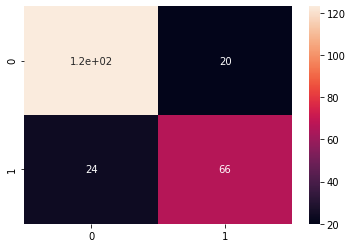

In [48]:
# plot confusion matrix
sns.heatmap(cf_mat,annot=True)

<AxesSubplot:>

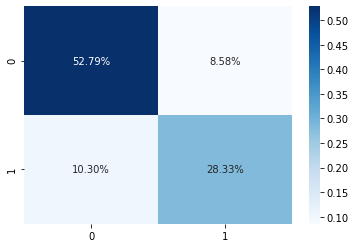

In [46]:
# plot percentage of data
sns.heatmap(cf_mat/np.sum(cf_mat),annot=True,
           fmt='.2%',cmap='Blues')